# Rice Plant Disease Detection

## Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import HTML

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.75
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Set all the contents

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

## Import data into tensorflow dataset object
We will use image_dataset_from_directory api to load all images in tensorflow dataset:

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/rsana/Downloads/Rice_Dataset_Original/1.Rice_Dataset_Original",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4437 files belonging to 9 classes.


In [5]:
class_names = dataset.class_names
class_names

['Brown_spot',
 'Healthy',
 'Hispa',
 'Shath Blight',
 'Tungro',
 'bacterial_leaf_blight',
 'leaf_blast',
 'leaf_scald',
 'narrow_brown_spot']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 8 5 8 8 4 1 4 4 0 0 6 6 3 8 1 1 8 4 4 8 7 5 7 5 4 0 4 6 6 0 7]


## Visualize some of the images from our dataset

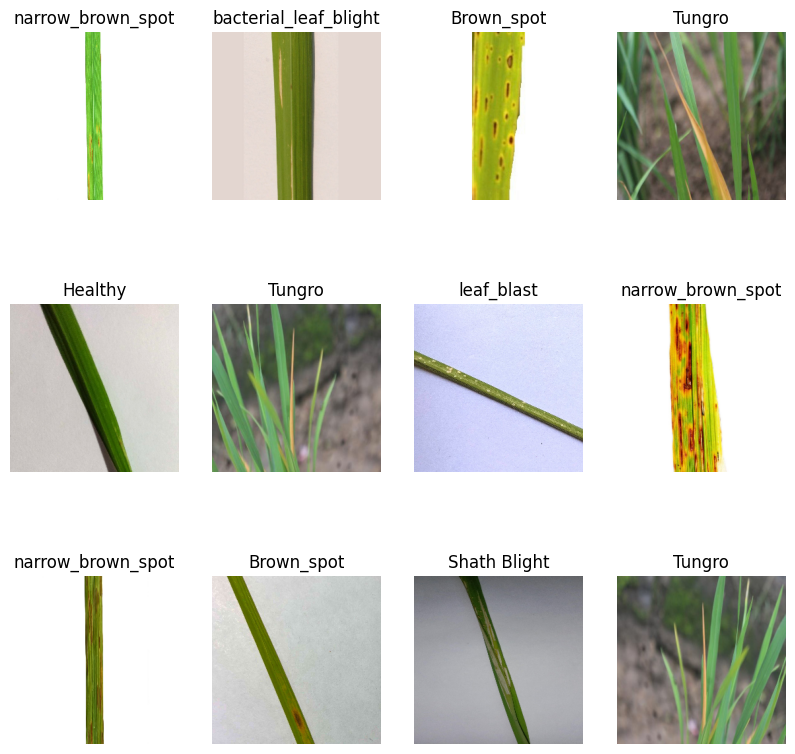

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Function to Split Dataset
### Dataset should be bifurcated into 3 subsets, namely:

#### 1.Training: Dataset to be used while training
#### 2.Validation: Dataset to be tested against while training
#### 3.Test: Dataset to be tested against after we trained a model

In [8]:
len(dataset)

139

In [9]:
train_size = 0.8
len(dataset)*train_size

111.2

In [10]:
train_ds = dataset.take(112)
len(train_ds)

112

In [11]:
test_ds = dataset.skip(112)
len(test_ds)

27

In [12]:
val_size=0.1
len(dataset)*val_size

13.9

In [13]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [14]:
test_ds = test_ds.skip(13)
len(test_ds)

14

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

111

In [18]:
len(val_ds)

13

In [19]:
len(test_ds)

15

### Cache, Shuffle, and Prefetch the Dataset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model
### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we 
should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

#### We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [24]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB1
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [25]:
image_size=[IMAGE_SIZE,IMAGE_SIZE]
n_classes = 9

efficientnet = EfficientNetB1(input_shape=image_size + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in efficientnet.layers:
    layer.trainable = False
    
# our layers - you can add more if you want
x = Flatten()(efficientnet.output)
prediction = Dense(n_classes, activation='softmax')(x)

# create a model object
model = Model(inputs=efficientnet.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling_1[0][0]']         
 on)                                                                                              
                                                                                                  
 rescaling_2 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0][0]']   

### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
111/111 [==============================] - 401s 3s/step - loss: 0.6492 - accuracy: 0.7779 - val_loss: 0.3648 - val_accuracy: 0.8870
Epoch 2/50
111/111 [==============================] - 336s 3s/step - loss: 0.3418 - accuracy: 0.8809 - val_loss: 0.3213 - val_accuracy: 0.8870
Epoch 3/50
111/111 [==============================] - 332s 3s/step - loss: 0.2677 - accuracy: 0.9060 - val_loss: 0.2577 - val_accuracy: 0.9183
Epoch 4/50
111/111 [==============================] - 327s 3s/step - loss: 0.2438 - accuracy: 0.9175 - val_loss: 0.2155 - val_accuracy: 0.9327
Epoch 5/50
111/111 [==============================] - 317s 3s/step - loss: 0.2246 - accuracy: 0.9234 - val_loss: 0.2615 - val_accuracy: 0.9327
Epoch 6/50
111/111 [==============================] - 316s 3s/step - loss: 0.2236 - accuracy: 0.9240 - val_loss: 0.1960 - val_accuracy: 0.9327
Epoch 7/50
111/111 [==============================] - 314s 3s/step - loss: 0.2073 - accuracy: 0.9307 - val_loss: 0.2106 - val_accuracy: 0.9303

In [28]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 42s 1s/step - loss: 0.1718 - accuracy: 0.9542


### Plotting the Accuracy and Loss Curves

In [29]:
history
history.params
history.history.keys()
type(history.history['loss'])
len(history.history['loss'])
history.history['loss'][:5] # show loss for first 5 epochs

[0.6491696238517761,
 0.34175199270248413,
 0.2677086889743805,
 0.24379044771194458,
 0.2246217429637909]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

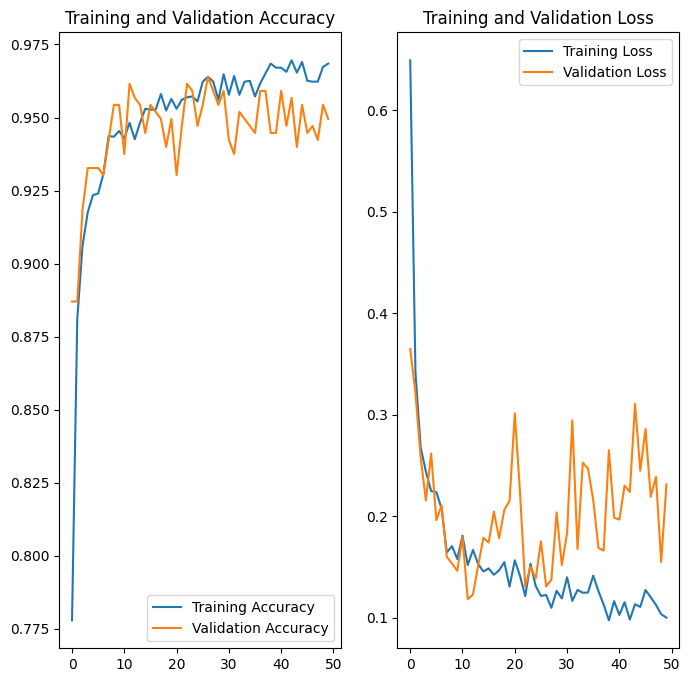

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: bacterial_leaf_blight
1/1 [==============================] - 1s 1s/step
predicted label: bacterial_leaf_blight


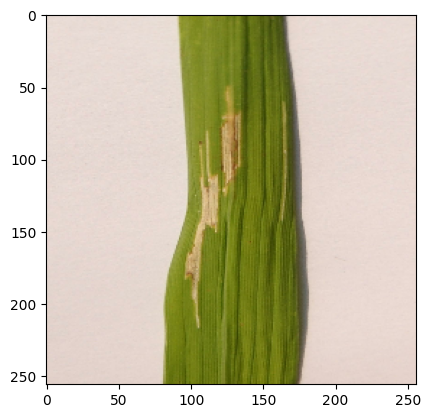

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Now run inference on few sample images

1/1 [==============================] - 0s 72ms/step


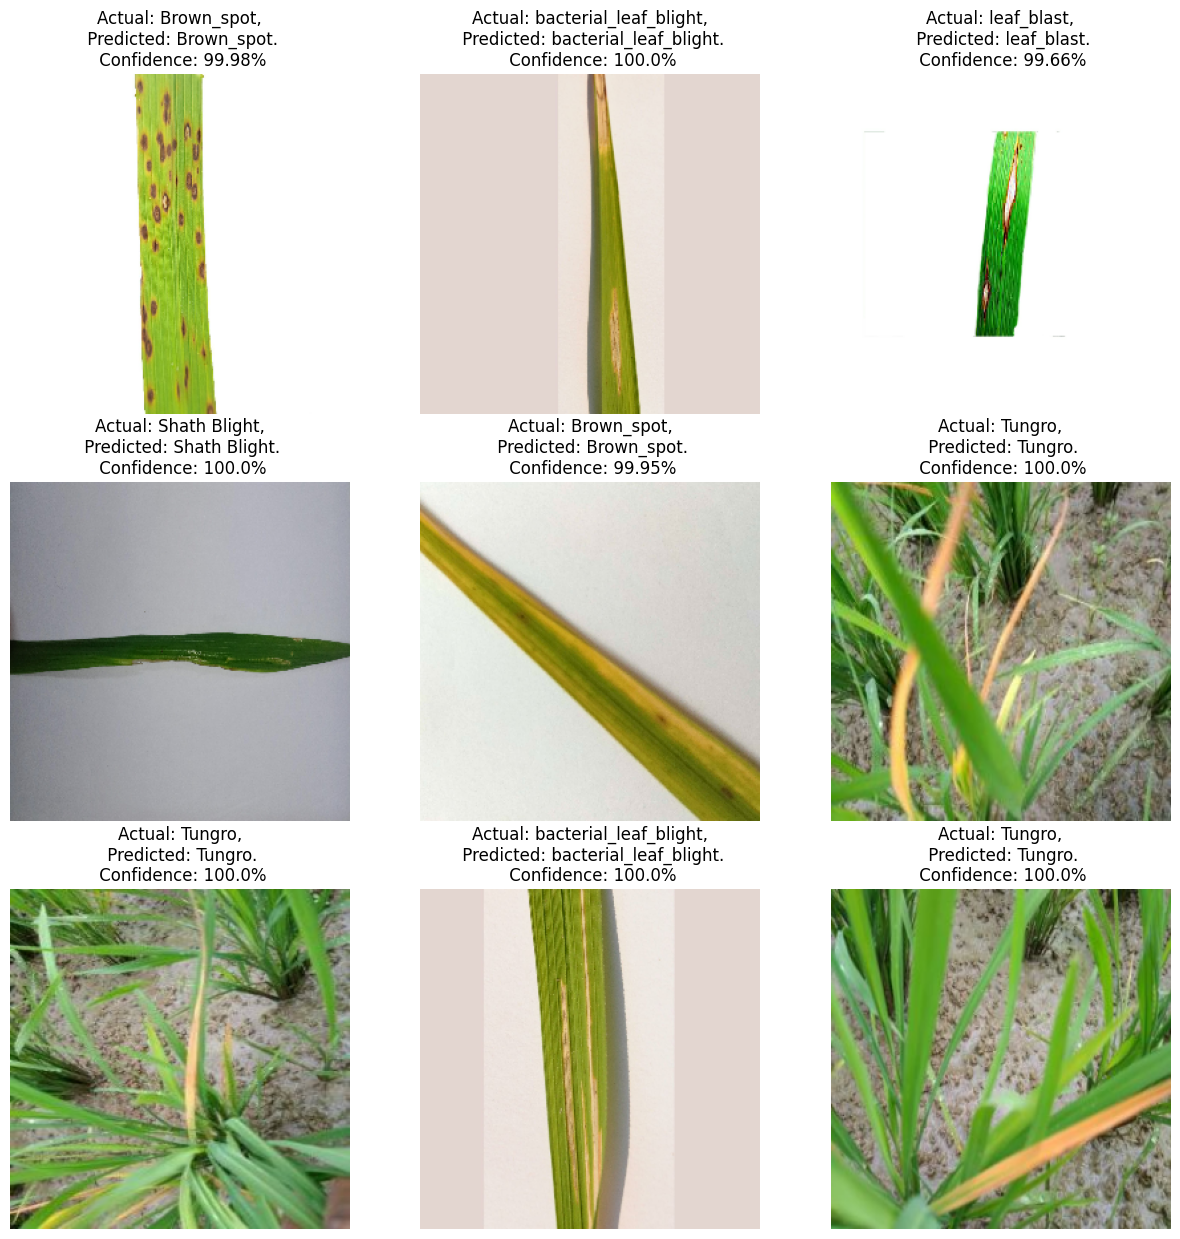

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")